# TODOS (Design):

1. Create the list of functions
2. Generate the Clean and Dirty datasets
3. Train on Clean and Dirty datasets
4. Repeat (3) for different activation functions (Tanh, Sigmoid, ReLU, PReLU, etc...)
5. For each function, create a figure depicting each model's predictions vs the real value
6. Compare the figures from (5) to see which activation functions performed better

# Importing Packages

In [1]:
import numpy as np
import torch
import torchvision
import random
import math

import pandas as pd
from sklearn.model_selection import train_test_split

# Training
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Loading Data

In [2]:
config = {
    'epochs': 3,
    'batch_size': 128,
    'lr': 0.001,
    'weight_decay': 1e-10,
    'random_state': 182,
    'transform': torchvision.transforms.Compose([
            torchvision.transforms.Resize((64, 64)),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.Normalize(mean=(0.0), std=(1.0))
        ]),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

# Training

### The Datasets

In [3]:
class CleanDataset(Dataset):
    def __init__(self, df_x, df_y, mode):
        self.data = df_x.copy().values
        img_shape = (int) (np.sqrt(self.data.shape[1]))
        self.data = torch.tensor(self.data.reshape(-1, 1, img_shape, img_shape), dtype=torch.float32)
        self.data = config['transform'](self.data)
        
        self.targets = torch.tensor(df_y.copy().values, dtype=torch.long)
        
        self.dim = self.data.shape[1]
        print('Finished creating the CLEAN {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))
        print("\tdata.shape = ", self.data.shape)
        print("\ttarget.shape = ", self.targets.shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [4]:
class DirtyDataset(Dataset):
    def __init__(self, df_x, df_y, mode, dirty_frac=0.1):
        self.data = df_x.copy().values
        img_shape = (int) (np.sqrt(self.data.shape[1]))
        self.data = torch.tensor(self.data.reshape(-1, 1, img_shape, img_shape), dtype=torch.float32)
        self.data = config['transform'](self.data)
        
        self.targets = torch.tensor(df_y.copy().values, dtype=torch.long)
        if mode == 'train':
            for i in range(len(self.targets)):
                make_dirty = random.random()  # random float in [0, 1)
                if make_dirty > dirty_frac:
                    continue
                original = self.targets[i].clone()
                while self.targets[i] == original:
                    self.targets[i] = random.randrange(0, 10)
                # print(f"{original} ({type(original)}) -> {self.y[i]} ({type(self.y[i])})")
            
        self.dim = self.data.shape[1]
        print('Finished creating the DIRTY {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))
        print("\tdata.shape = ", self.data.shape)
        print("\ttarget.shape = ", self.targets.shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

### The Models

In [5]:
# TODO: Tune this modela architecture
class Net(nn.Module):
    def __init__(self, AF, num_classes=10):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm2d(10),
            AF(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            AF(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(24),
            AF(),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(24*7*7, 512),
            nn.BatchNorm1d(512),
            AF(),
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            AF(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(128, num_classes),
        )

        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

### Making a static Utility helper class

In [6]:
class Utility:
    @staticmethod
    def train(model, trainLoader, valLoader):
        model = model.to(device)
        optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        lr_scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
        acc_record = {'train': [], 'val': []}
        for epoch in range(config['epochs']):
            running_loss = 0.0
            running_correct = 0.0
            running_size = 0
            model.train()
            with tqdm(trainLoader, unit='batch') as tepoch:
                for (data, target) in tepoch:
                    tepoch.set_description("Epoch: {epoch:>2}".format(epoch=epoch+1))
                    data, target = data.to(device), target.to(device)

                    optimizer.zero_grad()
                    outputs = model(data)
                    loss = model.cal_loss(outputs, target)
                    loss.backward(inputs=list(model.parameters()))
                    optimizer.step()

                    # print statistics
                    running_loss += loss.item() * data.size(0)
                    running_size += data.size(0)
                    out = torch.argmax(outputs.detach(), dim=1)
                    assert out.shape==target.shape
                    running_correct += (target==out).sum().item()
                    tepoch.set_postfix(train="{acc:<.4f}".format(acc=100*running_correct/running_size))
                    acc_record['train'].append(running_correct/running_size)
            
            model.eval()
            correct = 0
            with torch.no_grad():
                for data,target in valLoader:
                    out = model(data.to(device)).cpu()
                    out = torch.argmax(out.detach(),dim=1)
                    correct += (out==target).sum().item()
            acc_record['val'].append(correct/len(valLoader.dataset))
            print("val={0:<12f}".format(100*correct/len(valLoader.dataset)))
            lr_scheduler.step()
        return acc_record
            
    @staticmethod
    def plot_learning_curve(loss_record, title=''):
        ''' Plot learning curve of your DNN (train & dev loss) '''
        total_steps = len(loss_record['train'])
        x_1 = range(total_steps)
        offset = len(loss_record['train']) // len(loss_record['val'])
        x_2 = range(offset, total_steps + offset, offset)
        figure(figsize=(6, 4))
        plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
        plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
        plt.ylim(0.8, 1)
        plt.xlabel('Training steps')
        plt.ylabel('Accuracy')
        plt.title('Learning curve of {}'.format(title))
        plt.legend()
        plt.show()

    @staticmethod
    def plot_vals(clean, dirty, title='', num_std_devs=3):
        plt.plot(range(len(dirty)), dirty, label='dirty')
        plt.plot(range(len(clean)), clean, label='clean')
        y_lim_low = min(np.mean(clean) - num_std_devs * np.std(clean), 
                        np.mean(dirty) - num_std_devs * np.std(dirty))
        y_lim_high = max(np.mean(clean) + num_std_devs * np.std(clean), 
                        np.mean(dirty) + num_std_devs * np.std(dirty))
        plt.ylim(y_lim_low, y_lim_high)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Val Learning curve of {}'.format(title))
        plt.legend()
        plt.show()
            
    @staticmethod
    def plot_diff(diffs, labels, title='', num_std_devs=3):
        mins = []
        maxs = []
        for i in range(len(diffs)):
            plt.plot(range(len(diffs[i])), diffs[i], label=labels[i])
            mins.append(np.mean(diffs[i]) - num_std_devs * np.std(diffs[i]))
            maxs.append(np.mean(diffs[i]) + num_std_devs * np.std(diffs[i]))
        plt.ylim(min(mins), max(maxs))
        plt.xlabel('Training steps')
        plt.ylabel('Dirty Loss - Clean Loss')
        plt.title(title)
        plt.legend()
        plt.show()

    @staticmethod
    def list_mag_diff(list1, list2):
        answer = []
        for i in range(len(list1)):
            answer.append(abs(list1[i] - list2[i]))
        return answer

### Defining the Comparator

In [7]:
# this class handles multiple models where their only difference is the activation function
class AFComparator():
    def __init__(self):
        self.AFs = {
            'ReLU': nn.ReLU,
            'Leaky ReLU': nn.LeakyReLU,
            'PReLU': nn.PReLU,
            'ELU': nn.ELU,
            'Sigmoid': nn.Sigmoid,
            'Tanh': nn.Tanh,
            'Softsign': nn.Softsign
        }
        self.cleanRecords = {}
        self.dirtyRecords = {}
        df_train = pd.read_csv("data/MNIST/train.csv")
        X, y = df_train.drop(columns='label'), df_train['label']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=config['random_state'], stratify=y)
        df_test = pd.read_csv("data/MNIST/test.csv")
        
        self.tr_set_clean = CleanDataset(X_train, y_train, mode='train')
        self.val_set_clean = CleanDataset(X_val, y_val, mode='val')
        self.tr_set_dirty = DirtyDataset(X_train, y_train, mode='train')
        self.val_set_dirty = DirtyDataset(X_val, y_val, mode='val')

        self.train_loader_clean = DataLoader(self.tr_set_clean, batch_size=config['batch_size'], shuffle=True)
        self.val_loader_clean = DataLoader(self.val_set_clean, batch_size=config['batch_size'], shuffle=True)
        self.train_loader_dirty = DataLoader(self.tr_set_dirty, batch_size=config['batch_size'], shuffle=True)
        self.val_loader_dirty = DataLoader(self.val_set_dirty, batch_size=config['batch_size'], shuffle=True)

    def train_models(self):
        for i in range(len(self.AFs)):
            AFname, func = list(self.AFs.items())[i]
            print(f"Training Clean Model with {AFname}")
            clean_record = Utility.train(Net(func), self.train_loader_clean, self.val_loader_clean)
            print(f"Training Dirty Model with {AFname}")
            dirty_record = Utility.train(Net(func), self.train_loader_dirty, self.val_loader_dirty)
            self.cleanRecords[AFname] = clean_record
            self.dirtyRecords[AFname] = dirty_record

    def plot_learning_curves(self):
        for i in range(len(self.cleanRecords)):
            AF_name = list(self.AFs.keys())[i]
            clean_record = self.cleanRecords[AF_name]
            dirty_record = self.dirtyRecords[AF_name]
            Utility.plot_learning_curve(clean_record, title=f"{AF_name} model (Clean)")
            Utility.plot_learning_curve(dirty_record, title=f"{AF_name} model (Dirty)")

    def plot_val_comparison(self):
        for i in range(len(self.cleanRecords)):
            AF_name = list(self.AFs.keys())[i]
            clean_record = self.cleanRecords[AF_name]
            dirty_record = self.dirtyRecords[AF_name]
            Utility.plot_vals(clean_record['val'], dirty_record['val'], title=f"Clean vs Dirty ({AF_name})")

    def plot_diff_curves(self):
        diffs = []
        labels = []
        for i in range(len(self.cleanRecords)):
            AF_name = list(self.AFs.keys())[i]
            clean_record = self.cleanRecords[AF_name]
            dirty_record = self.dirtyRecords[AF_name]
            diffs.append(Utility.list_mag_diff(clean_record['val'], dirty_record['val']))
            labels.append(AF_name)
        Utility.plot_diff(diffs, labels, title='(Dirty - Clean) Val Loss')

    def make_submission(self):
        pass

In [8]:
comparator = AFComparator()

Finished creating the CLEAN train set of Dataset (35700 samples found, each dim = 1)
	data.shape =  torch.Size([35700, 1, 64, 64])
	target.shape =  torch.Size([35700])
Finished creating the CLEAN val set of Dataset (6300 samples found, each dim = 1)
	data.shape =  torch.Size([6300, 1, 64, 64])
	target.shape =  torch.Size([6300])
Finished creating the DIRTY train set of Dataset (35700 samples found, each dim = 1)
	data.shape =  torch.Size([35700, 1, 64, 64])
	target.shape =  torch.Size([35700])
Finished creating the DIRTY val set of Dataset (6300 samples found, each dim = 1)
	data.shape =  torch.Size([6300, 1, 64, 64])
	target.shape =  torch.Size([6300])


In [9]:
comparator.train_models()

Training Clean Model with ReLU


Epoch:  1: 100%|██████████| 279/279 [00:06<00:00, 42.34batch/s, train=92.5154]


val=98.396825   


Epoch:  2: 100%|██████████| 279/279 [00:04<00:00, 62.34batch/s, train=98.1793]


val=98.825397   


Epoch:  3: 100%|██████████| 279/279 [00:04<00:00, 60.44batch/s, train=98.5910]


val=99.031746   
Training Dirty Model with ReLU


Epoch:  1: 100%|██████████| 279/279 [00:04<00:00, 61.58batch/s, train=82.8964]


val=98.238095   


Epoch:  2: 100%|██████████| 279/279 [00:04<00:00, 61.98batch/s, train=88.3585]


val=98.634921   


Epoch:  3: 100%|██████████| 279/279 [00:04<00:00, 61.52batch/s, train=88.8992]


val=98.730159   
Training Clean Model with Leaky ReLU


Epoch:  1: 100%|██████████| 279/279 [00:04<00:00, 62.23batch/s, train=91.7619]


val=98.666667   


Epoch:  2: 100%|██████████| 279/279 [00:04<00:00, 62.32batch/s, train=98.2437]


val=98.841270   


Epoch:  3: 100%|██████████| 279/279 [00:04<00:00, 57.93batch/s, train=98.6583]


val=99.031746   
Training Dirty Model with Leaky ReLU


Epoch:  1: 100%|██████████| 279/279 [00:04<00:00, 56.55batch/s, train=83.1148]


val=98.063492   


Epoch:  2: 100%|██████████| 279/279 [00:04<00:00, 56.78batch/s, train=88.3473]


val=98.317460   


Epoch:  3: 100%|██████████| 279/279 [00:04<00:00, 56.78batch/s, train=88.8487]


val=98.412698   
Training Clean Model with PReLU


Epoch:  1: 100%|██████████| 279/279 [00:06<00:00, 44.25batch/s, train=92.5798]


val=98.285714   


Epoch:  2: 100%|██████████| 279/279 [00:06<00:00, 44.21batch/s, train=98.2157]


val=98.873016   


Epoch:  3: 100%|██████████| 279/279 [00:06<00:00, 44.23batch/s, train=98.7563]


val=98.952381   
Training Dirty Model with PReLU


Epoch:  1: 100%|██████████| 279/279 [00:06<00:00, 44.97batch/s, train=83.4482]


val=97.984127   


Epoch:  2: 100%|██████████| 279/279 [00:06<00:00, 44.67batch/s, train=88.3221]


val=98.555556   


Epoch:  3: 100%|██████████| 279/279 [00:06<00:00, 45.92batch/s, train=88.8123]


val=98.634921   
Training Clean Model with ELU


Epoch:  1: 100%|██████████| 279/279 [00:04<00:00, 56.80batch/s, train=92.6779]


val=97.650794   


Epoch:  2: 100%|██████████| 279/279 [00:04<00:00, 57.05batch/s, train=97.7815]


val=98.777778   


Epoch:  3: 100%|██████████| 279/279 [00:04<00:00, 56.31batch/s, train=98.3109]


val=98.952381   
Training Dirty Model with ELU


Epoch:  1: 100%|██████████| 279/279 [00:05<00:00, 55.38batch/s, train=83.0784]


val=97.873016   


Epoch:  2: 100%|██████████| 279/279 [00:04<00:00, 56.67batch/s, train=87.8768]


val=98.396825   


Epoch:  3: 100%|██████████| 279/279 [00:05<00:00, 54.67batch/s, train=88.3782]


val=98.650794   
Training Clean Model with Sigmoid


Epoch:  1: 100%|██████████| 279/279 [00:05<00:00, 54.78batch/s, train=79.8263]


val=95.793651   


Epoch:  2: 100%|██████████| 279/279 [00:04<00:00, 55.89batch/s, train=92.3922]


val=84.968254   


Epoch:  3: 100%|██████████| 279/279 [00:05<00:00, 55.43batch/s, train=91.7143]


val=92.063492   
Training Dirty Model with Sigmoid


Epoch:  1: 100%|██████████| 279/279 [00:05<00:00, 55.29batch/s, train=71.9300]


val=93.857143   


Epoch:  2: 100%|██████████| 279/279 [00:04<00:00, 56.58batch/s, train=82.2269]


val=89.920635   


Epoch:  3: 100%|██████████| 279/279 [00:04<00:00, 56.72batch/s, train=81.9328]


val=88.380952   
Training Clean Model with Tanh


Epoch:  1: 100%|██████████| 279/279 [00:04<00:00, 56.41batch/s, train=81.7283]


val=90.000000   


Epoch:  2: 100%|██████████| 279/279 [00:05<00:00, 54.53batch/s, train=89.9216]


val=92.222222   


Epoch:  3: 100%|██████████| 279/279 [00:05<00:00, 54.88batch/s, train=91.4594]


val=92.174603   
Training Dirty Model with Tanh


Epoch:  1: 100%|██████████| 279/279 [00:05<00:00, 51.22batch/s, train=72.6723]


val=88.285714   


Epoch:  2: 100%|██████████| 279/279 [00:05<00:00, 53.13batch/s, train=78.9552]


val=88.603175   


Epoch:  3: 100%|██████████| 279/279 [00:05<00:00, 54.88batch/s, train=80.0028]


val=89.809524   
Training Clean Model with Softsign


Epoch:  1: 100%|██████████| 279/279 [00:05<00:00, 48.96batch/s, train=84.4118]


val=94.841270   


Epoch:  2: 100%|██████████| 279/279 [00:05<00:00, 48.95batch/s, train=93.0168]


val=93.698413   


Epoch:  3: 100%|██████████| 279/279 [00:05<00:00, 50.79batch/s, train=93.1289]


val=93.666667   
Training Dirty Model with Softsign


Epoch:  1: 100%|██████████| 279/279 [00:05<00:00, 48.62batch/s, train=74.2269]


val=90.571429   


Epoch:  2: 100%|██████████| 279/279 [00:05<00:00, 48.93batch/s, train=81.7591]


val=92.412698   


Epoch:  3: 100%|██████████| 279/279 [00:05<00:00, 50.07batch/s, train=82.9048]


val=93.111111   


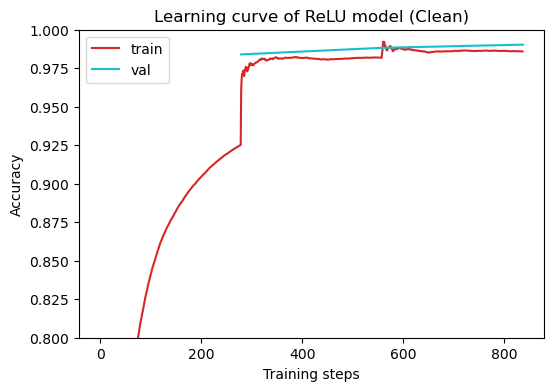

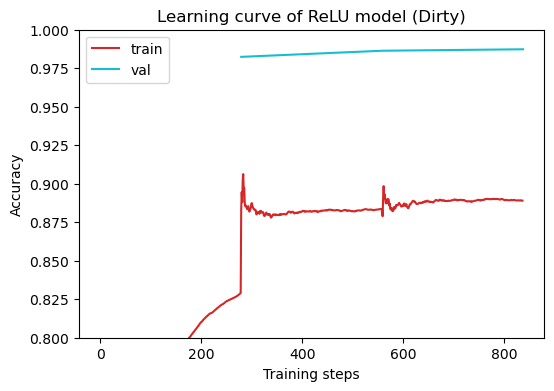

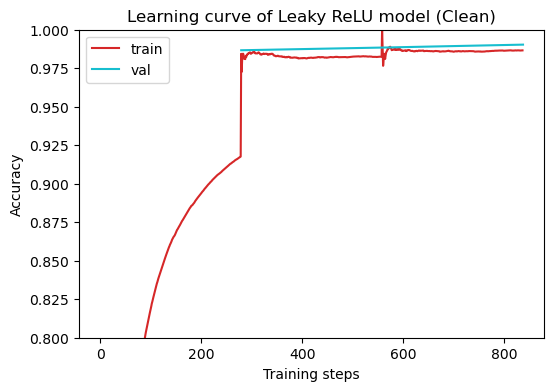

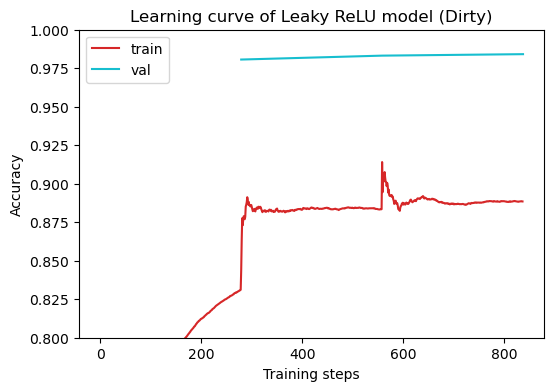

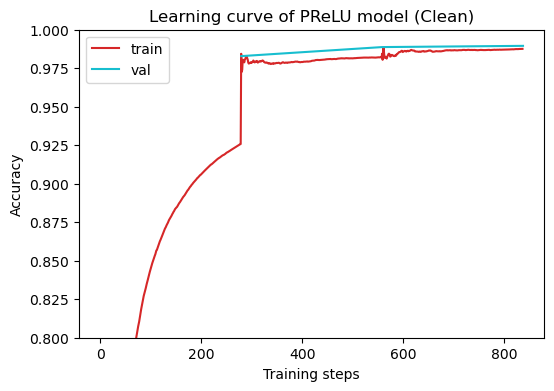

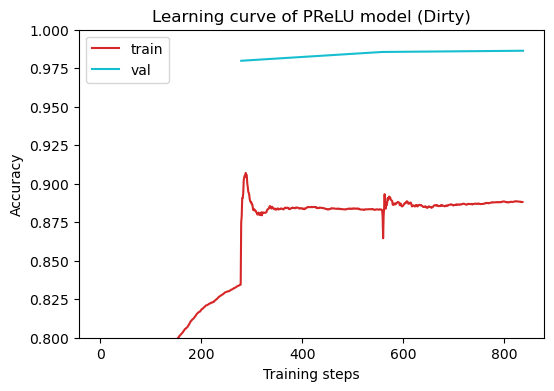

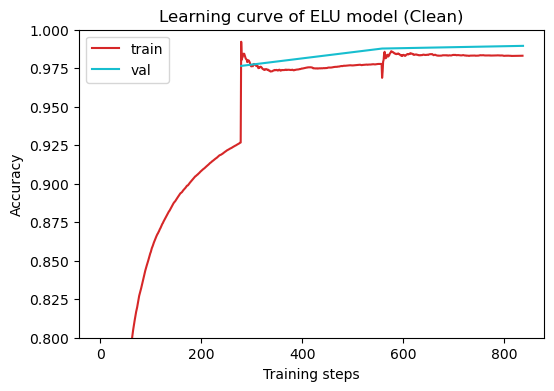

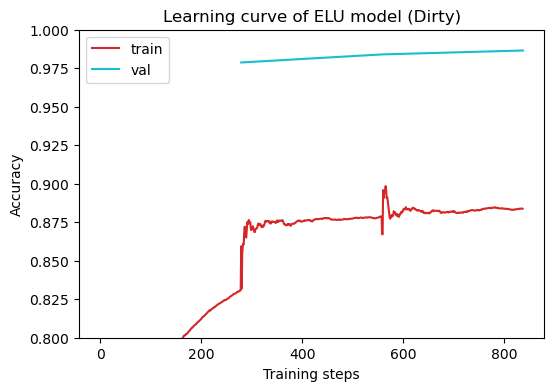

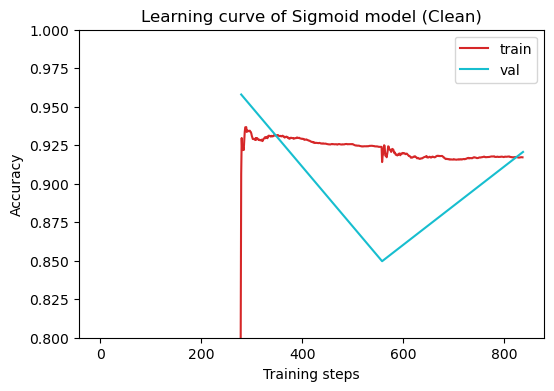

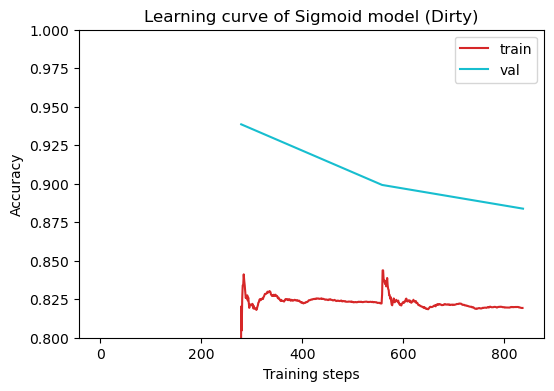

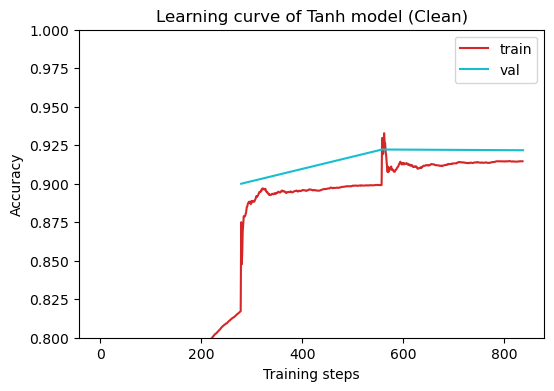

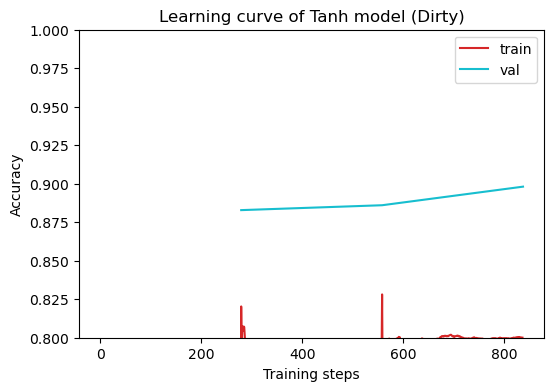

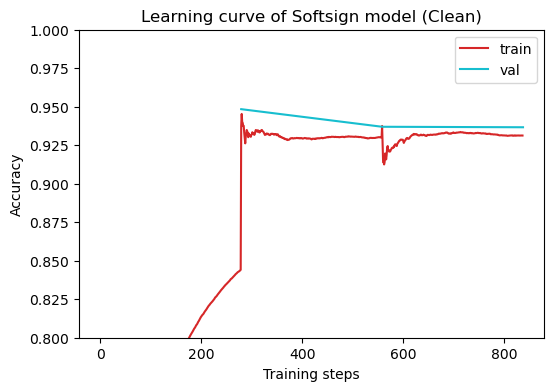

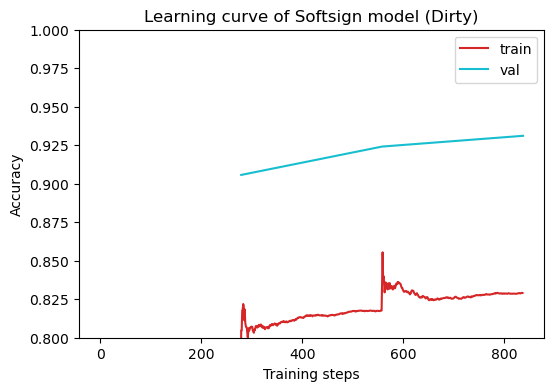

In [10]:
comparator.plot_learning_curves()

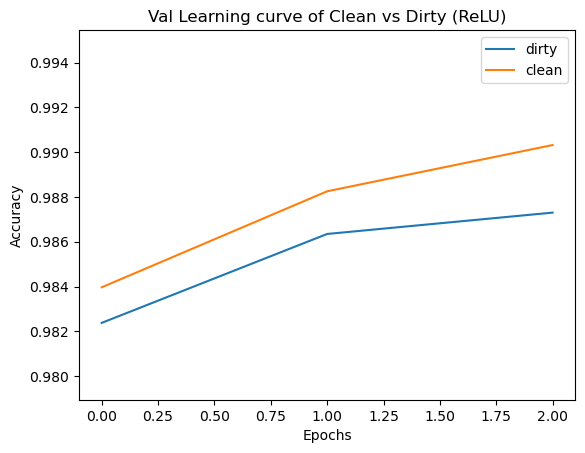

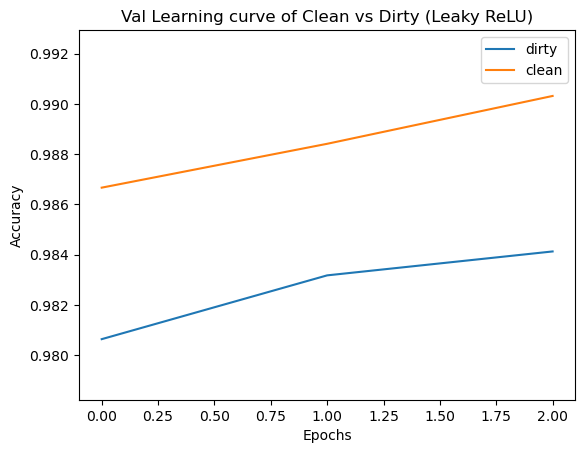

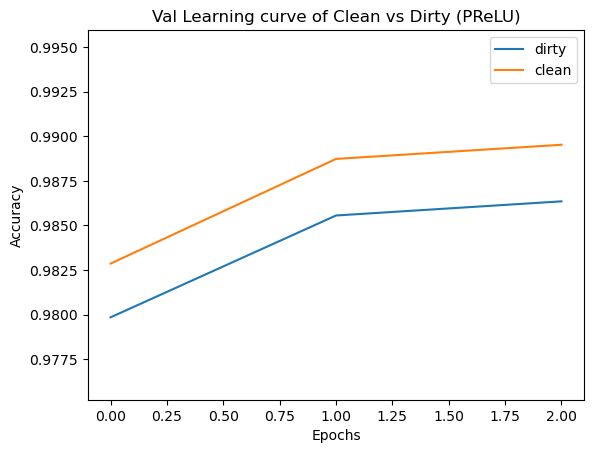

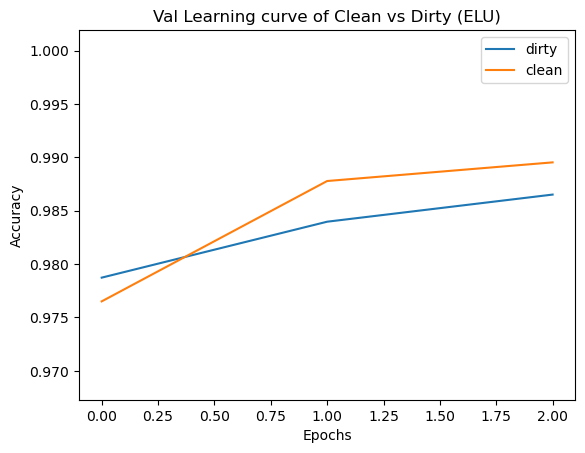

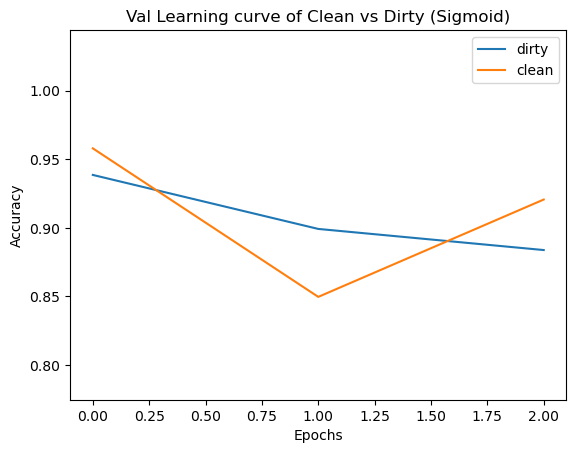

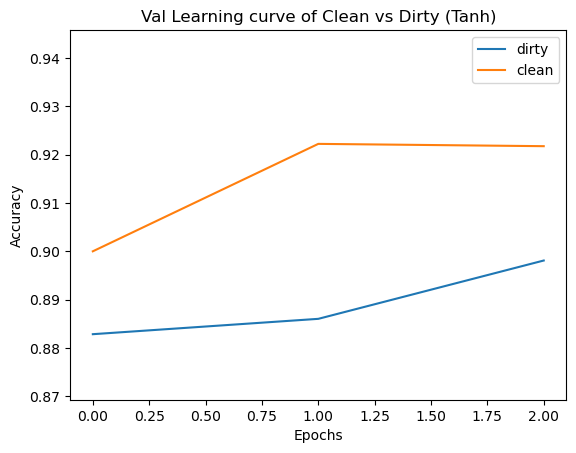

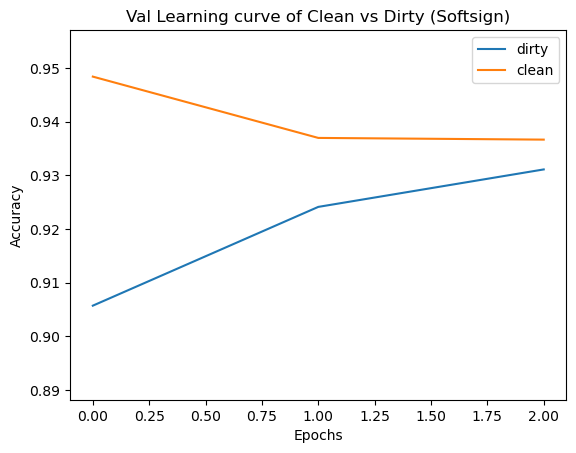

In [11]:
comparator.plot_val_comparison()

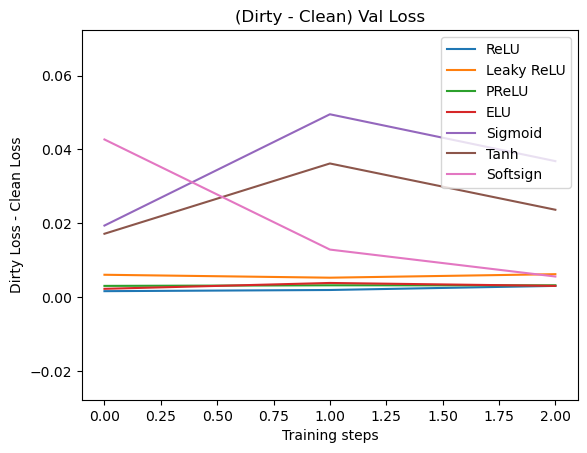

In [12]:
comparator.plot_diff_curves()